In [1]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

import math

import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *
from datetime import timedelta


In [2]:
df_to_forecasting = pd.read_csv(r'../data/updated_data_ind/ada_ind.csv')

In [3]:
df_ada = pd.read_csv(r'../data/cryptoInd/ada_ind.csv')
close = df_ada['close']
df_ada.drop('close', axis = 1, inplace = True)
df_ada['close'] = close

close = df_to_forecasting['close']
df_to_forecasting.drop('close', axis = 1, inplace = True)
df_to_forecasting['close'] = close

In [4]:
df_ada.head(10)

Date  adj_close       low      high      open       volume     SMA30  \
0  2017-12-12   0.133891  0.114222  0.138008  0.121177   60056800.0  0.120812   
1  2017-12-13   0.134281  0.122368  0.141854  0.133739   61575000.0  0.121781   
2  2017-12-14   0.240753  0.131843  0.240753  0.133667  309307008.0  0.131850   
3  2017-12-15   0.213467  0.187032  0.233209  0.233209  207311008.0  0.138089   
4  2017-12-16   0.404665  0.204233  0.447192  0.212875  581052032.0  0.156310   
5  2017-12-17   0.513011  0.378013  0.592417  0.386775  628142976.0  0.181687   
6  2017-12-18   0.518198  0.467403  0.526496  0.511939  253463008.0  0.207447   
7  2017-12-19   0.531273  0.501083  0.589589  0.520268  279631008.0  0.233807   
8  2017-12-20   0.486151  0.441621  0.533705  0.533705  182924000.0  0.257718   
9  2017-12-21   0.477851  0.456527  0.523619  0.490049  162926000.0  0.281719   

      CMA30     EMA30        adx  ...      macd  macdsignal  macdhist  \
0  0.069668  0.109170  62.460368  ...  0.026882    0.029637 -0.002755   
1  0.071514  0.112309  61.306445  ...  0.026730    0.029055 -0.002326   
2  0.076215  0.128364  61.955125  ...  0.034799    0.030204  0.004595   
3  0.079925  0.139002  62.560561  ...  0.038548    0.031873  0.006675   
4  0.088471  0.172210  64.167611  ...  0.056299    0.036758  0.019541   
5  0.099356  0.214810  65.918033  ...  0.078207    0.045048  0.033159   
6  0.109827  0.252734  67.551760  ...  0.094894    0.055017  0.039877   
7  0.120106  0.287551  69.155242  ...  0.107930    0.065600  0.042330   
8  0.128822  0.312376  69.238259  ...  0.113313    0.075142  0.038171   
9  0.136939  0.333060  69.315741  ...  0.115578    0.083229  0.032348   

         rsi     stdev      slowk      slowd  dollar_close  sp500_close  \
0  67.297379  0.012002  57.473092  47.064895     94.080002  2664.110107   
1  67.397316  0.012455  75.356559  59.419246     93.418999  2662.850098   
2  82.785435  0.030477  89.927456  74.252369     93.478996  2652.010010   
3  73.287491  0.036393  87.065078  84.116365     93.929001  2675.810059   
4  85.648895  0.075676  88.858253  88.616929     93.929001  2675.810059   
5  88.796609  0.116306  83.227207  86.383513     93.929001  2675.810059   
6  88.921253  0.142292  84.740127  85.608529     93.519997  2690.159912   
7  89.244429  0.161868  83.969821  83.979052     93.027000  2681.469971   
8  80.555716  0.170649  80.475814  83.061921     92.890999  2679.250000   
9  79.039120  0.174560  68.035752  77.493796     92.862000  2684.570068   

      close  
0  0.133891  
1  0.134281  
2  0.240753  
3  0.213467  
4  0.404665  
5  0.513011  
6  0.518198  
7  0.531273  
8  0.486151  
9  0.477851  

[10 rows x 23 columns]

In [5]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_ada['Date'], y=df_ada['close'], name='BITCOIN', mode='lines',line=dict(color='red')))
fig2.show()

In [6]:
inicial_date = '2021-02-13'
df_ada['Date'] = pd.to_datetime(df_ada['Date'])
df_to_forecasting['Date'] = pd.to_datetime(df_to_forecasting['Date'])
inicial_date = pd.to_datetime(inicial_date)
df_ada = df_ada[df_ada['Date'] >= inicial_date]
df_to_forecasting = df_to_forecasting[df_to_forecasting['Date'] >= inicial_date]

# Scaling

In [7]:
df_ada.set_index('Date', inplace=True)
scaled_df = df_ada.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_ada)
scaled_df = pd.DataFrame(scaled_feat, index = df_ada.index, columns=df_ada.columns)
scaled_df.head()

adj_close       low      high      open    volume     SMA30  \
Date                                                                      
2021-02-13   0.053071  0.052905  0.064893  0.062191  0.378971  0.000000   
2021-02-14   0.026764  0.044778  0.049511  0.053419  0.359014  0.014668   
2021-02-15   0.032545  0.000000  0.046710  0.026537  0.456398  0.030250   
2021-02-16   0.037108  0.056521  0.044990  0.032454  0.347739  0.044408   
2021-02-17   0.046276  0.049932  0.041400  0.037144  0.288533  0.058438   

               CMA30     EMA30       adx    bb_low  ...      macd  macdsignal  \
Date                                                ...                         
2021-02-13  0.000000  0.000000  0.910142  0.000000  ...  0.617451    0.548324   
2021-02-14  0.001650  0.010113  0.946499  0.017562  ...  0.614389    0.566729   
2021-02-15  0.003327  0.019722  0.929682  0.041494  ...  0.610537    0.580618   
2021-02-16  0.005024  0.028729  0.913987  0.063665  ...  0.605690    0.590677   
2021-02-17  0.006764  0.037815  0.892394  0.087565  ...  0.601703    0.597859   

            macdhist       rsi     stdev     slowk     slowd  dollar_close  \
Date                                                                         
2021-02-13  0.763153  0.973964  0.538724  0.877746  0.976558      0.069352   
2021-02-14  0.708716  0.824996  0.524787  0.747937  0.894459      0.069352   
2021-02-15  0.663447  0.834005  0.492144  0.635983  0.784047      0.069352   
2021-02-16  0.625070  0.841293  0.461039  0.592019  0.683358      0.072070   
2021-02-17  0.596237  0.856039  0.423695  0.670830  0.656186      0.108805   

            sp500_close     close  
Date                               
2021-02-13     0.161815  0.053071  
2021-02-14     0.161815  0.026764  
2021-02-15     0.161815  0.032545  
2021-02-16     0.159636  0.037108  
2021-02-17     0.158410  0.046276  

[5 rows x 22 columns]

# Correlation Matrix

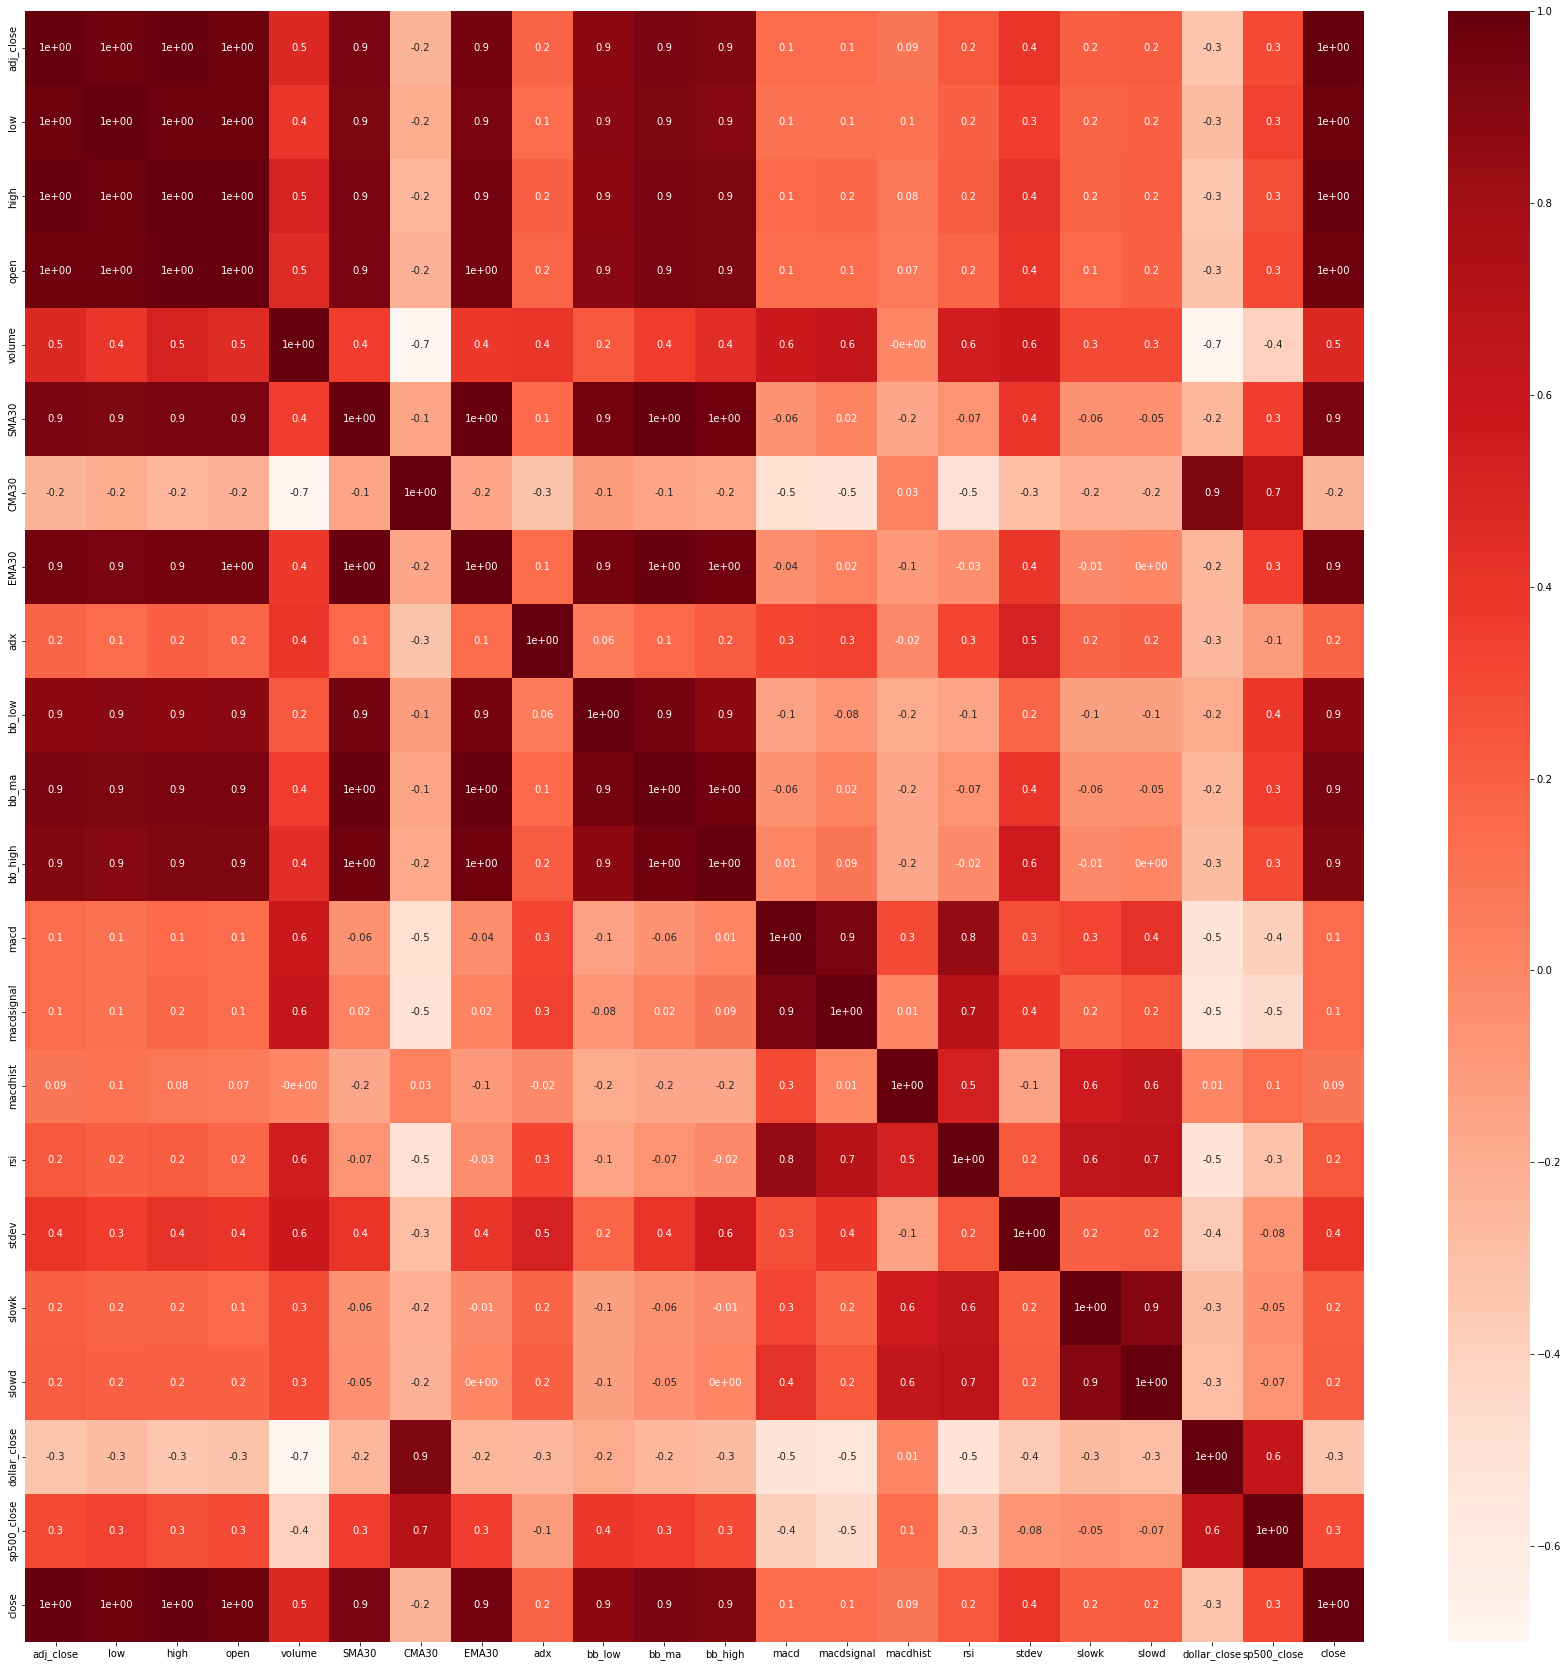

In [8]:
#Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

In [9]:
scaled_df.columns

Index(['adj_close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30', 'EMA30',
       'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal', 'macdhist',
       'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close', 'sp500_close',
       'close'],
      dtype='object')

In [10]:
df_ada.drop(['low', 'adj_close', 'open','EMA30',
 'bb_ma', 'bb_high'], axis=1, inplace=True)

df_to_forecasting.drop(['low', 'adj_close', 'open','EMA30',
 'bb_ma', 'bb_high'], axis=1, inplace=True)

## TimeBaseCV

In [11]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8"

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

# Models

## Function to Apply the Models

In [12]:
def add_days(df, forecast_length):
    end_point = len(df)
    df1 = pd.DataFrame(index=range(forecast_length), columns=range(2))
    df1.columns = ['close', 'Date']
    df = df.append(df1)
    df = df.reset_index(drop=True)
    x = df.at[end_point - 1, 'Date']
    x = pd.to_datetime(x, format='%Y-%m-%d')
    for i in range(forecast_length):
        df.at[df.index[end_point + i], 'Date'] = x + timedelta(days=1+i)
        df.at[df.index[end_point + i], 'close'] = 0
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.drop(['Date'], axis=1)
    return df

In [13]:
def forecasting(model,df1, forecast_length):
    df3 = df1[['close', 'Date']]
    df3 = add_days(df3, forecast_length)
    finaldf = df1.drop('Date', axis=1)
    finaldf = finaldf.reset_index(drop=True)
    end_point = len(finaldf)
    x = end_point - forecast_length
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'close']
    finaldf_train_y = finaldf_train['close']

    fit = model.fit(finaldf_train_x, finaldf_train_y)
    yhat = []
    end_point = len(finaldf)
    df3_end = len(df3)
    for i in range(forecast_length, 0, -1):
        y = end_point - i
        inputfile = finaldf.loc[y:end_point, :]
        inputfile_x = inputfile.loc[:, inputfile.columns != 'close']
        pred_set = inputfile_x.head(1)
        pred = fit.predict(pred_set)
        df3.at[df3.index[df3_end - i], 'close'] = pred[0]
        finaldf = df1.drop('Date', axis=1)
        finaldf = finaldf.reset_index(drop=True)
        yhat.append(pred)
    yhat = np.array(yhat)
    return yhat

In [14]:
def show_results(df_results, df,objetive,train_period_split,test_period_split, *args):
    #Scalling
    scaler = MinMaxScaler()
    scaled_feat = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_feat, index = df.index, columns=df.columns)

    X_scaled = scaled_df.drop(objetive, axis=1)
    y_scaled = scaled_df[objetive]

    X_tbcv = X_scaled.reset_index()
    y_scaled = y_scaled.reset_index()
    y_scaled['Date'] = pd.to_datetime(y_scaled['Date'], format='%Y-%m-%d')   
    X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
    tscv = TimeBasedCV(train_period=train_period_split,
        test_period=test_period_split,
        freq='days')
    colours =['red', 'blue', 'yellow', 'pink']
    fig2 = go.Figure()
    count = 0
    for idx,arg in enumerate(args):
        for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
            X_train = X_tbcv.loc[train_index]
            y_train = y_scaled.loc[train_index]
            X_train['close'] = y_train['close']
            y_test  = y_scaled.loc[test_index]
            X_test = X_tbcv.loc[test_index]
            X_test.set_index('Date', inplace=True)
            y_test.set_index('Date', inplace=True)
            mae_list = []
            mse_list = []
            r2_list = []
            rmse_list = []
            y_pred_test = forecasting(model=arg,df1=X_train,forecast_length=test_period_split)
            # prints metric results         
            value_mae = mean_absolute_error(y_test, y_pred_test)
            value_mse = mean_squared_error(y_test, y_pred_test)
            value_r2 = r2_score(y_test, y_pred_test)
            value_rmse = math.sqrt(value_mse)
            #print(value_mae, value_mse, value_r2)
            # append the accuracies, the time and the number of iterations in the corresponding list
            mae_list.append(value_mae)
            mse_list.append(value_mse)
            r2_list.append(value_r2)
            rmse_list.append(value_rmse)

            real_name = 'real '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to "\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            pred_name = 'pred '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to"\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            X_train['close'] = y_train['close']
            X_pred_test = X_test.copy()
            X_test['close'] = y_test['close']
            X_pred_test['close'] = y_pred_test
            X_pred_test_undo = scaler.inverse_transform(X_pred_test)
            X_test_undo = scaler.inverse_transform(X_test)

            X_pred_test_graphic = pd.DataFrame(data = X_pred_test_undo, index = X_pred_test.index, columns=X_pred_test.columns)
            X_test_graphic = pd.DataFrame(data =X_test_undo, index = X_test.index, columns=X_test.columns)

            fig2.add_trace(go.Scatter(x=X_test_graphic.index, y=X_test_graphic['close'], name=real_name, mode='lines',line=dict(color='green')))
            fig2.add_trace(go.Scatter(x=X_pred_test_graphic.index, y=X_pred_test_graphic['close'], name=pred_name, mode='lines', line=dict(color=colours[idx])))

        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))
        mae = round(np.mean(mae_list),10)
        mse = round(np.mean(mse_list),10)
        r2 = round(np.mean(r2_list),10)
        rmse = round(np.mean(rmse_list),10)
        df_results.iloc[count] = mae, mse,rmse, r2
        count+=1
    fig2.show()
    return df_results
        
    

## Random Forest

In [15]:
rf_se = RandomForestRegressor(random_state=10,criterion='mse')
rf_ae = RandomForestRegressor(random_state=10,criterion='mae')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mse','mae'])
show_results(df, df_ada,'close',100,5, rf_se, rf_ae)

MAE       MSE      RMSE        R2
mse  0.005198  0.000035  0.005942  0.684879
mae  0.005236  0.000035   0.00593  0.686088

In [16]:
rf_5 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5)
rf_20 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20)
rf_50 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=50)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['5','20', '50'])
show_results(df, df_ada,'close',100,5,rf_5, rf_20,rf_50)

MAE       MSE     RMSE        R2
5   0.005843  0.000044  0.00667  0.602934
20  0.005236  0.000035  0.00593  0.686088
50  0.005236  0.000035  0.00593  0.686088

In [17]:
rf_auto = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto')
rf_sqrt = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='sqrt')
rf_log2 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20,max_features='log2' )
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_ada,'close',100,5,rf_auto, rf_sqrt,rf_log2)

MAE       MSE      RMSE        R2
auto  0.005236  0.000035   0.00593  0.686088
sqrt  0.012797  0.000228  0.015105 -1.036604
log2  0.012797  0.000228  0.015105 -1.036604

In [18]:
rf_10 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto', n_estimators=50)
rf_20 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto',n_estimators=100)
rf_30 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20,max_features='auto', n_estimators=150)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['50','100', '150'])
show_results(df, df_ada,'close',100,5,rf_10, rf_20,rf_30)

MAE       MSE      RMSE        R2
50   0.005041   0.00003  0.005503  0.729696
100  0.005236  0.000035   0.00593  0.686088
150  0.005333  0.000038  0.006179  0.659163

In [19]:
rf_final = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto', n_estimators=50)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_ada,'close',100,5, rf_final)

MAE      MSE      RMSE        R2
final  0.005041  0.00003  0.005503  0.729696

## Gradient Boost

In [20]:
gb_mae = GradientBoostingRegressor(random_state = 10 , criterion='mae')
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='mse')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mae','mse'])
show_results(df, df_ada,'close',100,5,gb_mae, gb_mse)

MAE       MSE      RMSE        R2
mae  0.005694  0.000046  0.006772  0.590695
mse  0.007065   0.00008  0.008931  0.288019

In [21]:
gb_50 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 50)
gb_100 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 100)
gb_150 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 150)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['50','100', '150'])
show_results(df, df_ada,'close',100,5,gb_50, gb_100, gb_150)

MAE       MSE      RMSE        R2
50   0.005053  0.000046  0.006767  0.591245
100  0.005694  0.000046  0.006772  0.590695
150  0.006466  0.000052  0.007225  0.534114

In [22]:
gb_auto = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 50, max_features=  'auto' )
gb_sqrt = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 50, max_features = 'sqrt')
gb_log2 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 50, max_features=  'log2')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_ada,'close',100,5,gb_auto, gb_sqrt, gb_log2)

MAE       MSE      RMSE        R2
auto  0.005053  0.000046  0.006767  0.591245
sqrt  0.017113  0.000397  0.019924 -2.543073
log2  0.017113  0.000397  0.019924 -2.543073

In [23]:
gb_final = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 50, max_features=  'auto')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['final'])
show_results(df, df_ada,'close',100,5,gb_final)

MAE       MSE      RMSE        R2
final  0.005053  0.000046  0.006767  0.591245

## Neural Nerworks

In [24]:
nn_2525 = MLPRegressor(hidden_layer_sizes=(25,25), random_state=15,max_iter = 3000)
nn_10101010 = MLPRegressor(hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)
nn_10 = MLPRegressor(hidden_layer_sizes=(40,40), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['2525','101010', '10'])
show_results(df, df_ada,'close',100,5,nn_2525, nn_10101010, nn_10)

MAE       MSE      RMSE         R2
2525    0.059576  0.003712   0.06093 -32.136311
101010  0.047012  0.002722  0.052177 -23.300166
10      0.078402  0.007354  0.085757 -64.642746

In [25]:
nn_identity = MLPRegressor(activation = 'identity',hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)
nn_logistic = MLPRegressor(activation = 'logistic',hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)
nn_tanh = MLPRegressor(activation = 'tanh',hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)
nn_relu = MLPRegressor(activation = 'relu',hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['identity','logistic', 'tanh', 'relu'])
show_results(df, df_ada,'close',100,5,nn_identity, nn_logistic, nn_tanh, nn_relu)

MAE       MSE      RMSE          R2
identity  0.192211  0.037632   0.19399 -334.895709
logistic  0.029319  0.000967  0.031097    -7.63158
tanh      0.126128  0.016495  0.128433 -146.230903
relu      0.047012  0.002722  0.052177  -23.300166

In [26]:
nn_lbfgs = MLPRegressor(solver = 'lbfgs', activation = 'relu',hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)
nn_sgd = MLPRegressor(solver = 'sgd', activation = 'relu',hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)
nn_adam = MLPRegressor(solver = 'adam', activation = 'relu',hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['lbfgs','sgd', 'adam'])
show_results(df, df_ada,'close',100,5,nn_lbfgs, nn_sgd, nn_adam)

MAE       MSE      RMSE         R2
lbfgs  0.005694  0.000039  0.006241   0.652336
sgd    0.065961  0.004589  0.067745 -39.963245
adam   0.047012  0.002722  0.052177 -23.300166

In [27]:
nn_constant = MLPRegressor(learning_rate = 'constant',solver = 'lbfgs', activation = 'relu',
hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)
nn_invscaling = MLPRegressor(learning_rate = 'invscaling',solver = 'lbfgs', activation = 'relu',
hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)
nn_adaptive = MLPRegressor(learning_rate = 'adaptive',solver = 'lbfgs', activation = 'relu',
hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['constant','invscaling', 'adaptive'])
show_results(df, df_ada,'close',100,5,nn_constant, nn_invscaling, nn_adam)

MAE       MSE      RMSE         R2
constant    0.005694  0.000039  0.006241   0.652336
invscaling  0.005694  0.000039  0.006241   0.652336
adaptive    0.047012  0.002722  0.052177 -23.300166

In [28]:
nn_final = MLPRegressor(learning_rate = 'constant',solver = 'lbfgs', activation = 'relu',
hidden_layer_sizes=(30,30), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['final'])
show_results(df, df_ada,'close',100,5,nn_final)

MAE       MSE      RMSE        R2
final  0.005694  0.000039  0.006241  0.652336

## XGBoost

In [29]:
xgb_mae = XGBRegressor(random_state = 10 , criterion='absolute_error')
xgb_mse = XGBRegressor(random_state = 10 , criterion='squared_error')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['mae','mse'])
show_results(df, df_ada,'close',100,5,xgb_mae, xgb_mse)

[21:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:11:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:11:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could b

MAE       MSE      RMSE        R2
mae  0.013564  0.000242  0.015561 -1.161454
mse  0.013564  0.000242  0.015561 -1.161454

In [30]:
xgb_150 = XGBRegressor(random_state = 10 , n_estimators=150)
xgb_200 = XGBRegressor(random_state = 10 , n_estimators=200)
xgb_250 = XGBRegressor(random_state = 10 , n_estimators=250)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['150','200','250'])
show_results(df, df_ada,'close',100,5,xgb_150, xgb_200,xgb_250)

MAE       MSE      RMSE        R2
150  0.013564  0.000242  0.015561 -1.161454
200  0.013564  0.000242  0.015561 -1.161454
250  0.013564  0.000242  0.015561 -1.161454

In [31]:
xgb_gbtree = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130)
xgb_gblinear = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130)
xgb_dart = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['gbtree','gblinear','dart'])

show_results(df, df_ada,'close',100,5,xgb_gbtree, xgb_gblinear,xgb_dart )

MAE       MSE      RMSE        R2
gbtree    0.013564  0.000242  0.015561 -1.161454
gblinear  0.007295  0.000067  0.008198   0.40016
dart      0.013563  0.000242  0.015561 -1.161405

In [32]:
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True)
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])
show_results(df, df_ada,'close',100,5,xgb_true, xgb_false)

MAE       MSE      RMSE        R2
True   0.009945  0.000135  0.011631 -0.207389
False  0.020636  0.000455  0.021336 -3.063116

In [33]:
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True,disable_default_eval_metric=False)
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True,disable_default_eval_metric=True)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])
show_results(df, df_ada,'close',100,5,xgb_true, xgb_false)

MAE       MSE      RMSE        R2
True   0.029356  0.000897  0.029947 -7.004904
False  0.024824  0.000642  0.025343  -4.73257

In [34]:
xgb_005 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True,disable_default_eval_metric=True,eta = 0.05)
xgb_01 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True,disable_default_eval_metric=True,eta = 0.1)
xgb_03 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True,disable_default_eval_metric=True,eta = 0.3)
xgb_05 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True,disable_default_eval_metric=True,eta = 0.5)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['0,05', '0,1', '0,3', '0,5'])
show_results(df, df_ada,'close',100,5, xgb_005,xgb_01, xgb_03, xgb_05 )

MAE       MSE      RMSE        R2
0,05  0.019377  0.000409  0.020227 -2.651917
0,1   0.008995  0.000102  0.010108  0.088032
0,3   0.022621  0.000547  0.023387 -3.882046
0,5   0.006227  0.000049  0.006982  0.564864

In [35]:
xgb_final = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True,disable_default_eval_metric=True,eta = 0.1)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_ada,'close',100,5, xgb_final)

MAE       MSE      RMSE        R2
final  0.021047  0.000471  0.021694 -3.200877

# Results

In [37]:
df_to_forecasting.tail()

Date      high        volume     SMA30     CMA30        adx  \
1604 2022-05-04  0.897661  1.516023e+09  0.849491  0.497303  34.225205   
1605 2022-05-05  0.904111  1.802129e+09  0.839745  0.497483  32.660696   
1606 2022-05-06  0.798315  1.312284e+09  0.831271  0.497657  31.423201   
1607 2022-05-07  0.785116  8.015589e+08  0.821586  0.497818  30.534651   
1608 2022-05-08  0.763704  1.092425e+09  0.811977  0.497968  30.026620   

        bb_low      macd  macdsignal  macdhist        rsi     stdev  \
1604  0.736649 -0.050276   -0.050850  0.000574  49.946956  0.056421   
1605  0.733901 -0.050391   -0.050758  0.000367  40.706136  0.052922   
1606  0.729145 -0.050528   -0.050712  0.000184  40.120282  0.051063   
1607  0.722577 -0.051774   -0.050925 -0.000849  38.484785  0.049505   
1608  0.712832 -0.053557   -0.051451 -0.002106  37.160800  0.049572   

          slowk      slowd  dollar_close  sp500_close     close  
1604  54.104035  39.534149    102.594002  4300.169922  0.896942  
1605  51.157710  46.840462    103.802002  4146.870117  0.791152  
1606  47.130912  50.797552    103.694000  4123.339844  0.783359  
1607  16.390186  38.226269    103.694000  4123.339844  0.761882  
1608   9.875911  24.465669    103.694000  4123.339844  0.744362

In [39]:
forecasting(rf_final,df_to_forecasting,2)

array([[0.78309315],
       [0.78747645]])

In [41]:
forecasting(nn_final,df_to_forecasting,2)

array([[566.07590337],
       [529.16959102]])

In [42]:
forecasting(gb_final,df_to_forecasting,2)

array([[0.80614808],
       [0.79745193]])

In [43]:
forecasting(xgb_final,df_to_forecasting,2)

array([[0.7454429],
       [0.7338353]], dtype=float32)